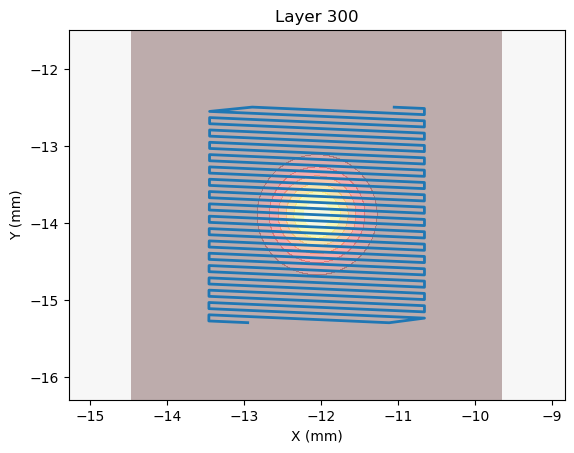

In [14]:
import tkinter as tk
from tkinter import filedialog, ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import re

def parse_cli(filepath):
    layers = {}
    units = 1.0
    current_layer = None
    metadata = {}

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()

            if line.startswith("$$UNITS/"):
                units = float(line.split("/")[1])

            elif line.startswith("$$LAYER/"):
                current_layer = int(line.split("/")[1])
                layers[current_layer] = {'paths': [], 'power': None, 'speed': None, 'focus': None}

            elif line.startswith("$$POWER/") and current_layer is not None:
                layers[current_layer]['power'] = float(line.split("/")[1])

            elif line.startswith("$$SPEED/") and current_layer is not None:
                layers[current_layer]['speed'] = float(line.split("/")[1])

            elif line.startswith("$$FOCUS/") and current_layer is not None:
                layers[current_layer]['focus'] = float(line.split("/")[1])

            elif line.startswith("$$HATCHES/") and current_layer is not None:
                parts = line.split(",")[2:]  # Skip $$HATCHES and count
                coords = list(map(int, parts))
                points = [(coords[i] * units, coords[i + 1] * units) for i in range(0, len(coords), 2)]
                # Group as polylines based on breaks
                layers[current_layer]['paths'].append(points)

    return layers

def gaussian_heatmap(x, y, x0, y0, sigma=0.4):
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

class ToolPathApp:
    def __init__(self, root):
        self.root = root
        self.root.title("CLI Viewer with Heatmap")

        self.layers = {}
        self.selected_layer = tk.IntVar()
        self.setup_ui()

    def setup_ui(self):
        top = tk.Frame(self.root)
        top.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)

        tk.Button(top, text="Load CLI", bg="#4CAF50", fg="white", command=self.load_file).pack(side=tk.LEFT, padx=5)

        self.layer_menu = ttk.Combobox(top, textvariable=self.selected_layer, state="readonly")
        self.layer_menu.pack(side=tk.LEFT, padx=5)
        self.layer_menu.bind("<<ComboboxSelected>>", lambda e: self.update_plot())

        self.meta_label = tk.Label(top, text="", fg="#555")
        self.meta_label.pack(side=tk.LEFT, padx=10)

        self.fig, self.ax = plt.subplots()
        self.ax.set_facecolor("#f7f7f7")
        self.canvas = FigureCanvasTkAgg(self.fig, self.root)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def load_file(self):
        path = filedialog.askopenfilename(filetypes=[("CLI files", "*.cli")])
        if not path:
            return
        self.layers = parse_cli(path)
        layer_keys = sorted(self.layers.keys())
        self.layer_menu["values"] = layer_keys
        self.selected_layer.set(layer_keys[0])
        self.update_plot()

    def update_plot(self):
        self.ax.clear()
        layer_id = self.selected_layer.get()
        if layer_id not in self.layers:
            return

        layer = self.layers[layer_id]
        paths = layer["paths"]
        colors = plt.cm.tab20(np.linspace(0, 1, len(paths)))

        all_x, all_y = [], []

        for i, path in enumerate(paths):
            x, y = zip(*path)
            self.ax.plot(x, y, color=colors[i], linewidth=2)
            all_x.extend(x)
            all_y.extend(y)

        if all_x and all_y:
            x0, y0 = np.mean(all_x), np.mean(all_y)
            xg, yg = np.meshgrid(
                np.linspace(min(all_x)-1, max(all_x)+1, 100),
                np.linspace(min(all_y)-1, max(all_y)+1, 100)
            )
            z = gaussian_heatmap(xg, yg, x0, y0)
            self.ax.contourf(xg, yg, z, alpha=0.3, cmap="hot")

        self.ax.set_title(f"Layer {layer_id}")
        self.ax.set_xlabel("X (mm)")
        self.ax.set_ylabel("Y (mm)")
        self.ax.axis("equal")

        meta = f"Power: {layer['power']} | Speed: {layer['speed']} | Focus: {layer['focus']}"
        self.meta_label.config(text=meta)

        self.canvas.draw()

if __name__ == "__main__":
    root = tk.Tk()
    app = ToolPathApp(root)
    root.mainloop()
